In [1]:
# pre requisites
!pip install numpy
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 3.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 4.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
# extract input embeddings as input.txt
# python extract_embeddings_input.py --model TinyLlama/TinyLlama-1.1B-Chat-v1.0 --tokenizer TinyLlama/TinyLlama-1.1B-Chat-v1.0 --prompt "I like to listen to music on my" --output_prefix radio/input
#
# extract embeddings from the hidden layers
# python extract_embeddings_hidden_all.py --model TinyLlama/TinyLlama-1.1B-Chat-v1.0 --tokenizer TinyLlama/TinyLlama-1.1B-Chat-v1.0 --prompt "I like to listen to music on my" --output_prefix radio/embeddings
#

# Define locations and tokens
words= [ "<s>", "I", "like", "to", "listen", "to", "music", "on", "my"]
skip_first_token=1 # skip showing the first token e.g. "<s>"
inputfolder = "radio/"
png_prefix = "radio-images/single"

# Load embeddings
#dimensions = numpy.empty((0, 2048))   # replace below if don't want to load initial input embeddings from extract_embeddings_input.py
dimensions = numpy.loadtxt(inputfolder+"input.txt")

# Load embeddings from each hidden layer
for layer in range(0,23):
    layer_embeddings = numpy.loadtxt(inputfolder+"embeddings-"+str(layer)+".txt")
    dimensions = numpy.vstack((dimensions,layer_embeddings))

# Apply t-sne to all embeddings
data = numpy.array(dimensions)
tsne = TSNE(n_components=2, metric="nan_euclidean", max_iter=1000, perplexity=3, method="exact")
data_2d = tsne.fit_transform(data)

/tmp/ipykernel_700/2464492752.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


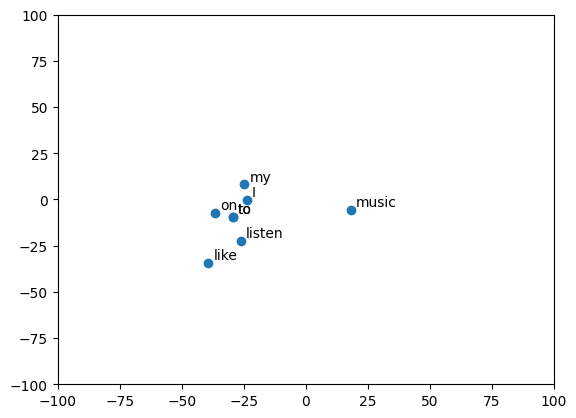

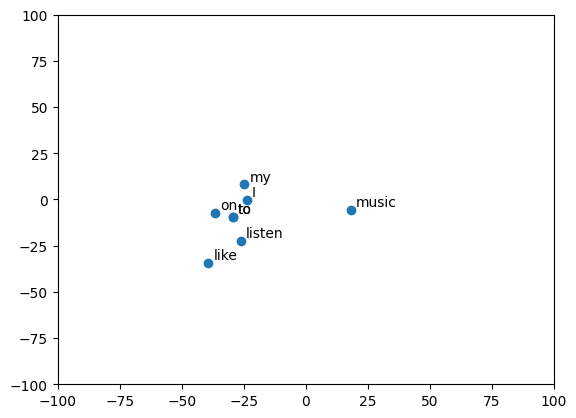

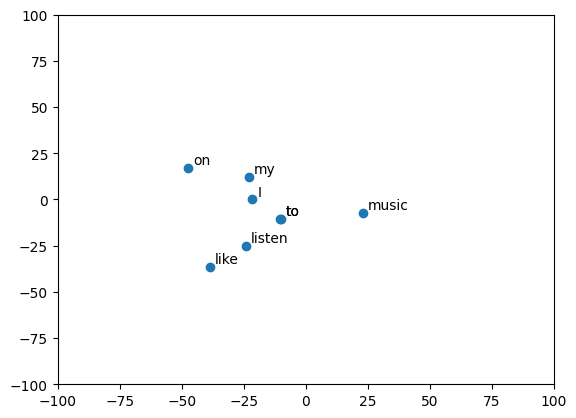

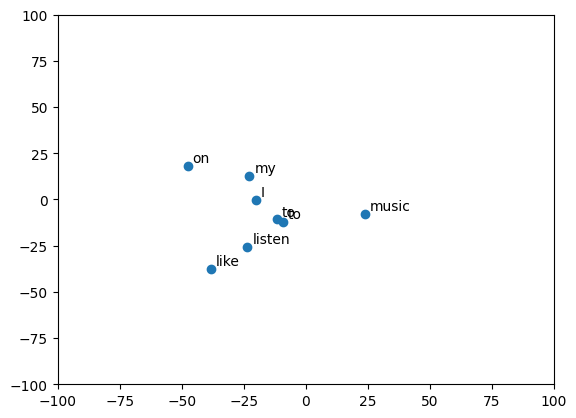

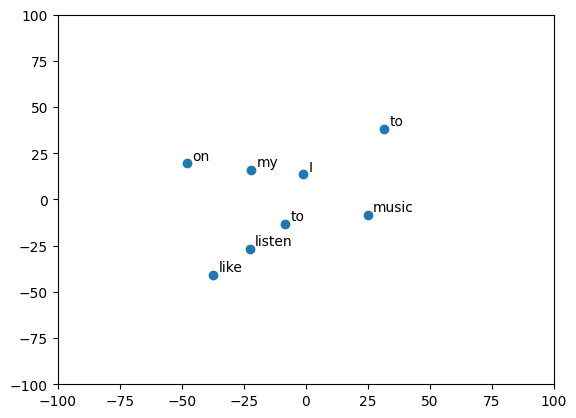

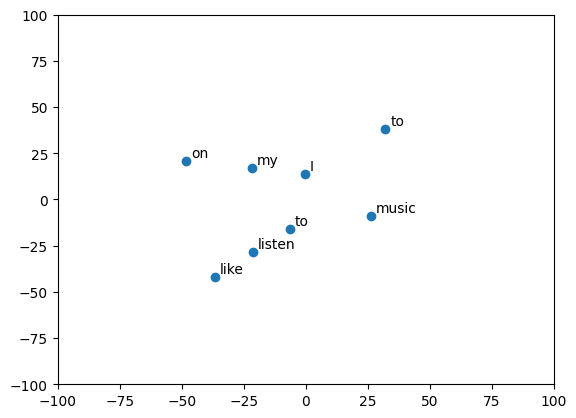

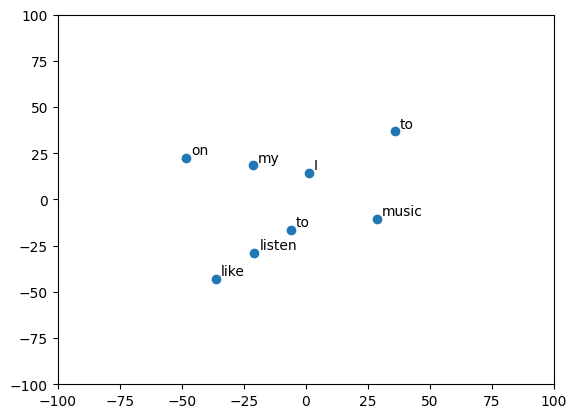

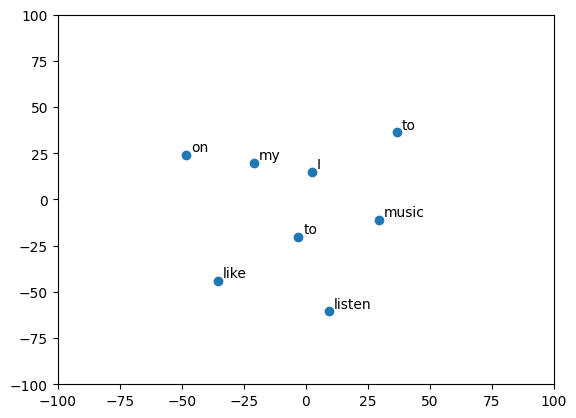

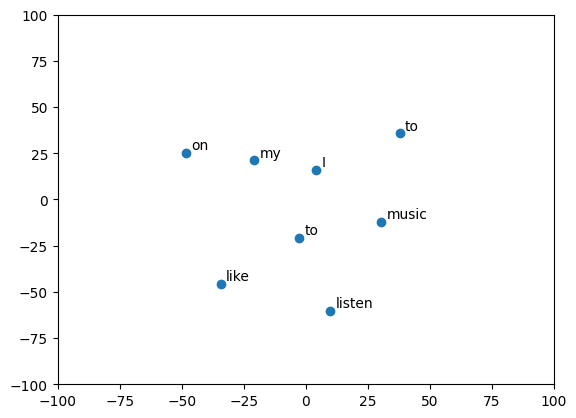

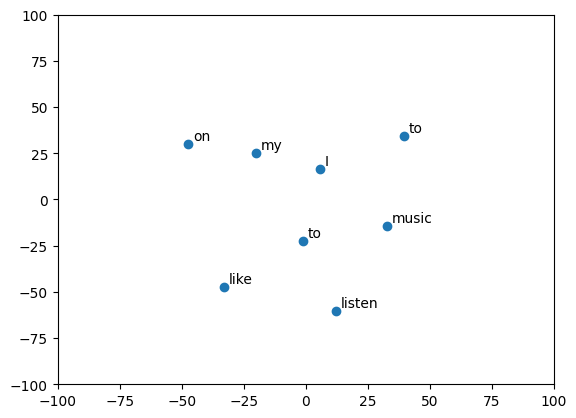

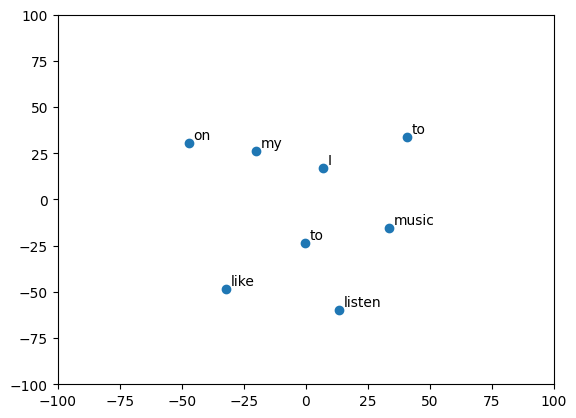

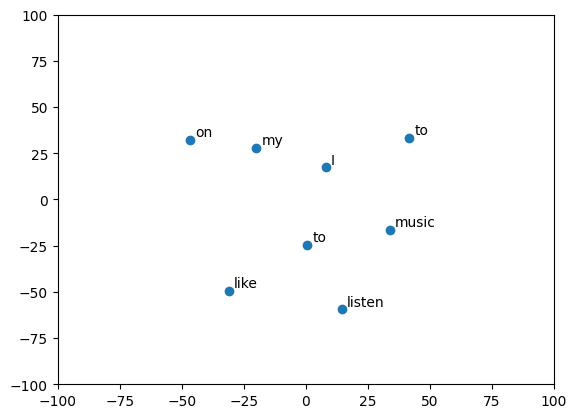

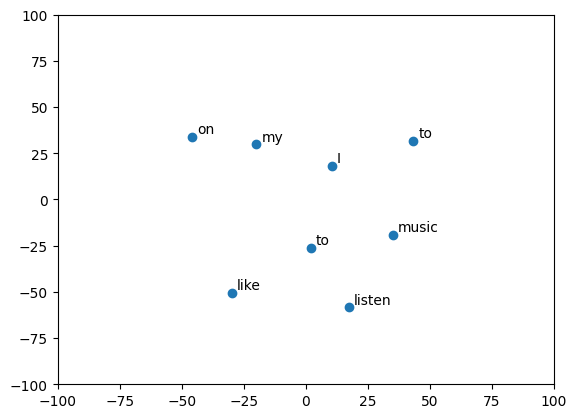

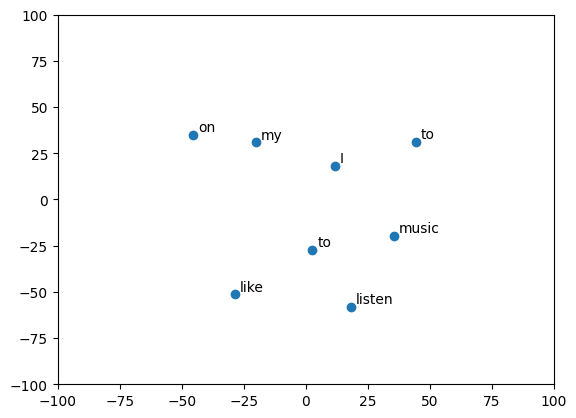

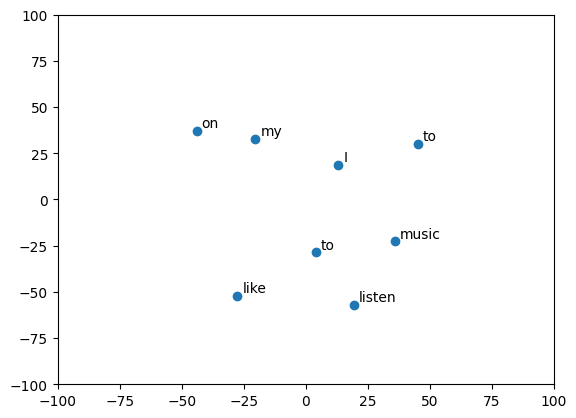

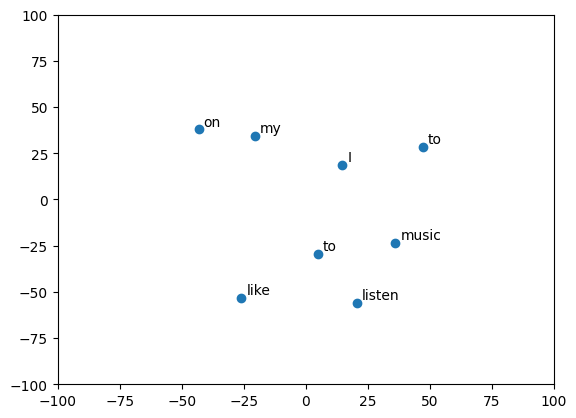

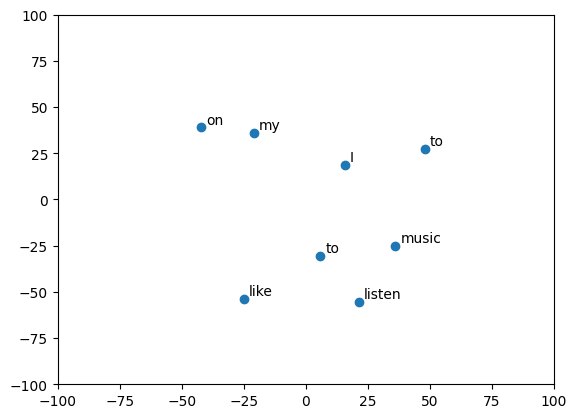

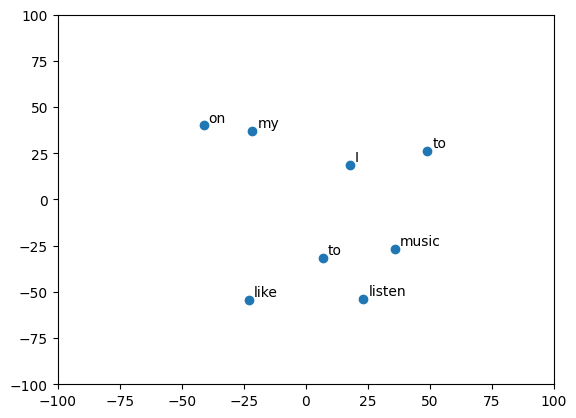

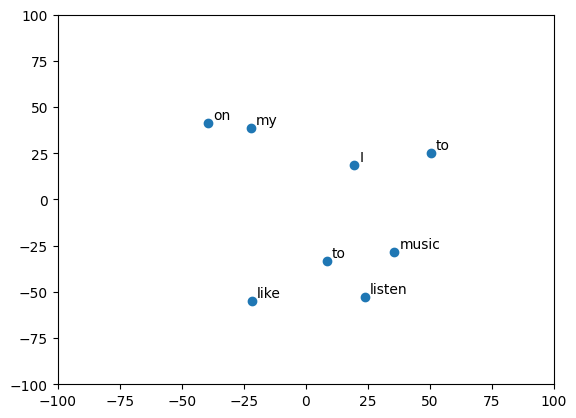

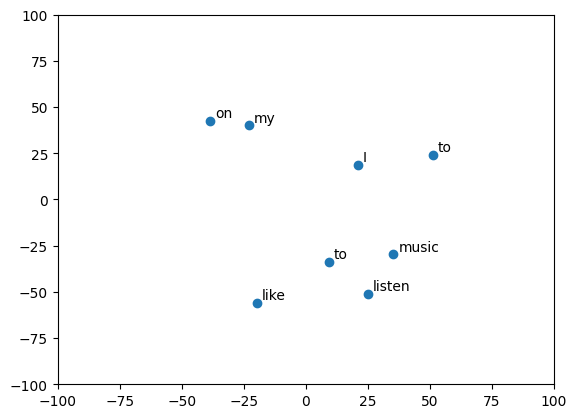

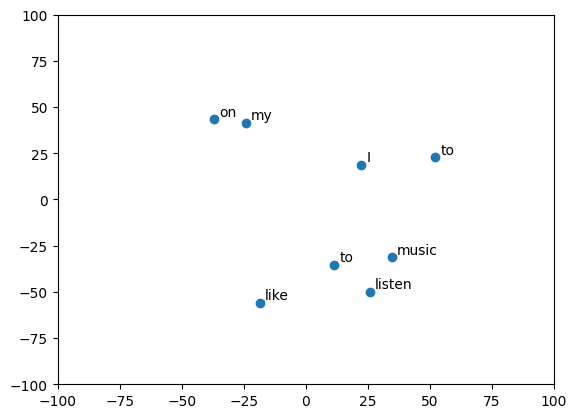

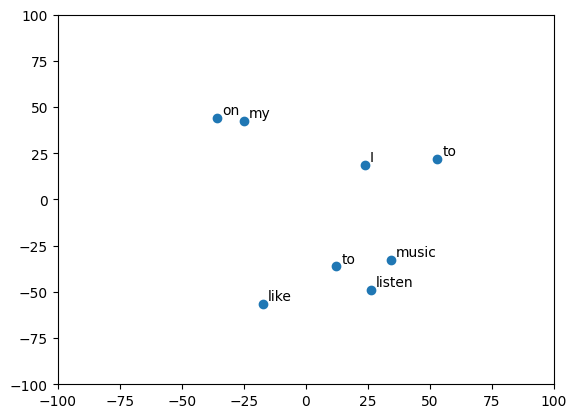

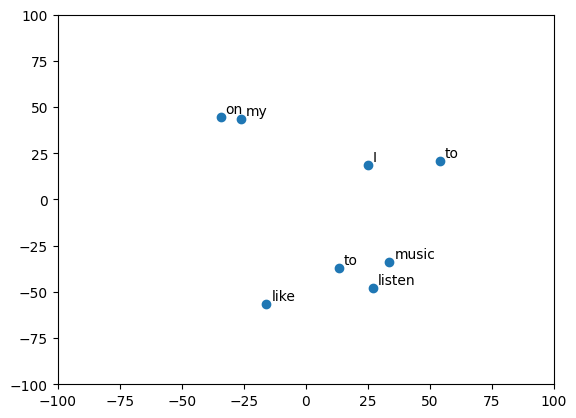

In [4]:
# plt and save graphs
for layer in range(0,23):
    
    fig, ax = plt.subplots()
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)

    # calc this renders start and end tokens - use skip_first_token = 1 or =0
    layer_start_index = (layer * len(words))+skip_first_token
    layer_end_index = layer_start_index + len(words) -skip_first_token

    # Plot token positions
    ax.scatter(data_2d[layer_start_index:layer_end_index,0], data_2d[layer_start_index:layer_end_index,1])

    # label tokens 
    for i,pos in enumerate(data_2d[layer_start_index:layer_end_index]):
        ax.annotate(words[i+skip_first_token], (pos[0], pos[1]), xytext=(pos[0]+2, pos[1]+2),)
        
    # save the plot
    plt.savefig(png_prefix+"-"+str(layer)+".png")
